We've talked about using Stable Diffusion to generate a new version of the logo on our
landing page every day. Stable diffusion alone hasn't been able to generate anything meaningful, but
let's try creating seed images with DalleMini and then use Stable Diffusion img2img to refine them.

_Based on: https://github.com/huggingface/diffusers/blob/main/README.md#image-to-image-text-guided-generation-with-stable-diffusion_

In [ ]:
!pip install git+https://github.com/run-house/runhouse.git@latest_patch

In [ ]:
import runhouse as rh
import torch
from PIL import Image
import random

### Login to Runhouse to load in secrets.

In [ ]:
# You can add token=<your token> if you want to be able to run this without pasting into stdin
rh.login(download_secrets=True, download_config=True, interactive=True)

In [ ]:
# Only if you're using GCP and running inside Colab!
!gcloud init
!gcloud auth application-default login
!cp -r /content/.config/* ~/.config/gcloud

In [ ]:
# Check that secrets are loaded in properly and at least one cloud is ready to use.
!sky check

First let's try DALL-E. It runs well on an Ampere GPU, but AWS doesn't offer single A100s (only clusters of 8), so we can either run it on an A10G or an A100 on GCP or Azure (we're using an A100 below, but you can uncomment the A10G line to use that instead). See this [amazing guide by Paperspace](https://www.paperspace.com/gpu-cloud-comparison) for more on who offers what GPUs.

The first time we run this cell it will take 5-10 minutes to allocate and set up the hardware. After the cluster is up, it only takes ~15 seconds.

In [ ]:
def unclip_generate(prompt, model_id='kakaobrain/karlo-v1-alpha', num_images=1, **model_kwargs):
    import runhouse as rh
    from diffusers import UnCLIPPipeline
    import torch
    pipe = rh.get_pinned_object(model_id)
    if pipe is None:
        pipe = UnCLIPPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda')
        rh.pin_to_memory(model_id, pipe)
    return pipe([prompt], num_images_per_prompt=num_images, **model_kwargs).images

gpu = rh.cluster(name='rh-a10x', instance_type='A100:1')  # On GCP and Azure
# gpu = rh.cluster(name='rh-a10x', instance_type='g5.2xlarge', provider='aws')  # On AWS
generate_karlo_gpu = rh.send(fn=unclip_generate, 
                             hardware=gpu,
                             reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                             name='karlo_generate').save()

The first time we run this cell it will take ~8 minutes to download the model, which is pretty large. Subsequent calls will only take ~1 second per image (in part because we've pinned the model to GPU memory!).

INFO | 2023-01-19 02:25:12,192 | Running karlo_generate via SSH
INFO | 2023-01-19 02:25:17,583 | Time to send message: 5.38 seconds


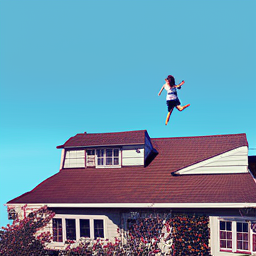

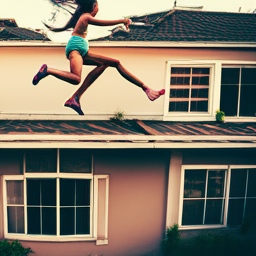

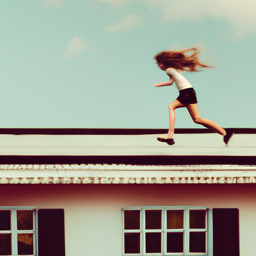

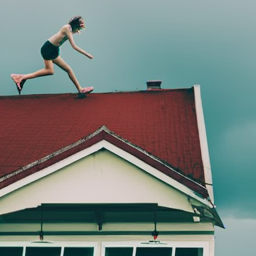

[None, None, None, None]

In [ ]:
rh_prompt = 'A digital photo of a woman running on the roof of a house.'

rh_logo_dalle_images = generate_karlo_gpu(rh_prompt, num_images=4)
[display(image) for image in rh_logo_dalle_images]

Now let's try feeding these into StableDiffusionImg2Img. Let's see if we have enough GPU memory to put it on our A10G/A100. If now, we can just put it on a V100 (on any provider, it doesn't matter).

In [ ]:
gpu.run(['nvidia-smi'])
True

INFO | 2023-01-19 02:20:29,984 | Running command on rh-a10x: nvidia-smi


Thu Jan 19 02:20:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    50W / 400W |  14971MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Looks like we're ok to put StableDiffusion (~5.2GB) on our A10G/A100 too.

In [ ]:
def sd_img2img_generate(prompt, base_images, num_images=1,
                        steps=50, strength=0.75, guidance_scale=7.5,
                        model_id="stabilityai/stable-diffusion-2-base"):
    import runhouse as rh
    from diffusers import StableDiffusionImg2ImgPipeline
    import torch
    pipe = rh.get_pinned_object(model_id + 'im2img')
    if pipe is None:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to('cuda')
        rh.pin_to_memory(model_id + 'im2img', pipe)
    ret = []
    for image in base_images:
        ret = ret + pipe([prompt] * num_images, init_image=image.resize((512, 512)),
                         num_inference_steps=steps, strength=strength,
                         guidance_scale=guidance_scale).images
    return ret

sd_img2img_generate_gpu = rh.send(fn=sd_img2img_generate, hardware=gpu,
                                  reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                                  name='sd_img2img_generate').save()

INFO | 2023-01-19 02:21:00,255 | Writing out send function to /content/sd_img2img_generate_fn.py as functions serialized in notebooks are brittle. Please make sure the function does not rely on any local variables, including imports (which should be moved inside the function body).
INFO | 2023-01-19 02:21:00,260 | Setting up Send on cluster.
INFO | 2023-01-19 02:21:00,263 | Copying local package content to cluster <rh-a10x>
INFO | 2023-01-19 02:21:00,352 | Installing packages on cluster rh-a10x: ['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116', 'diffusers', 'transformers', 'accelerate']
INFO | 2023-01-19 02:21:00,378 | Send setup complete.


This too will take ~3 minutes to run the first time to download the model, and after that should only take ~1 second per image.

INFO | 2023-01-19 02:25:23,753 | Running sd_img2img_generate via SSH
INFO | 2023-01-19 02:25:31,861 | Time to send message: 8.1 seconds


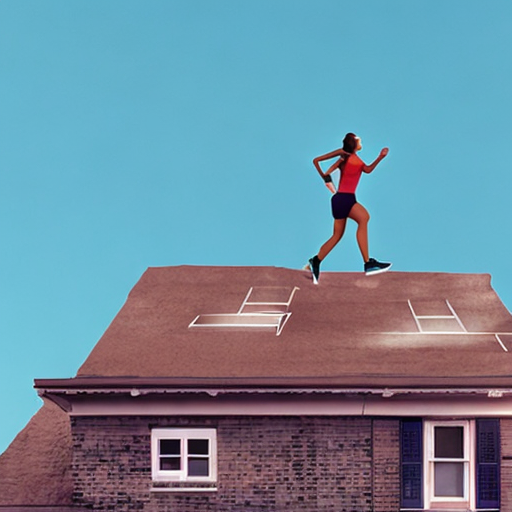

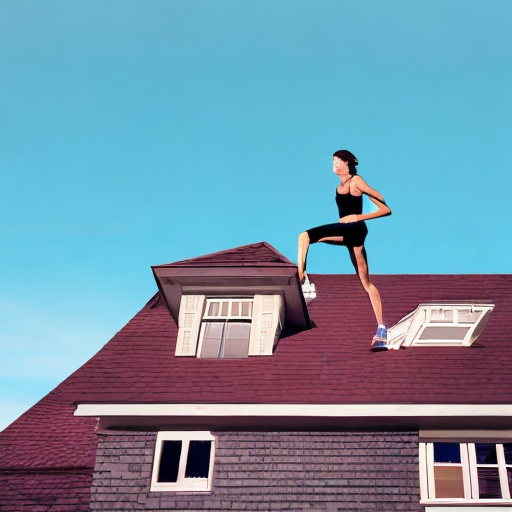

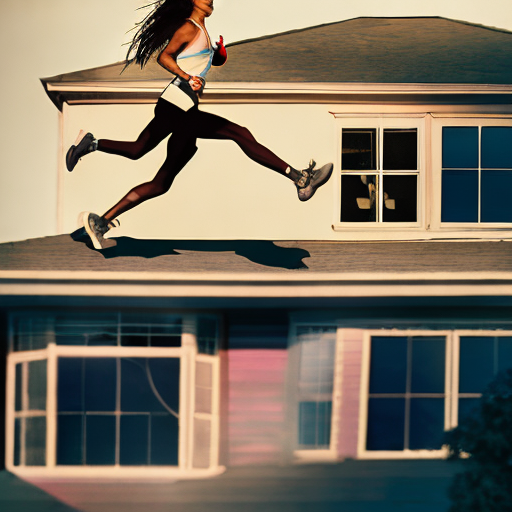

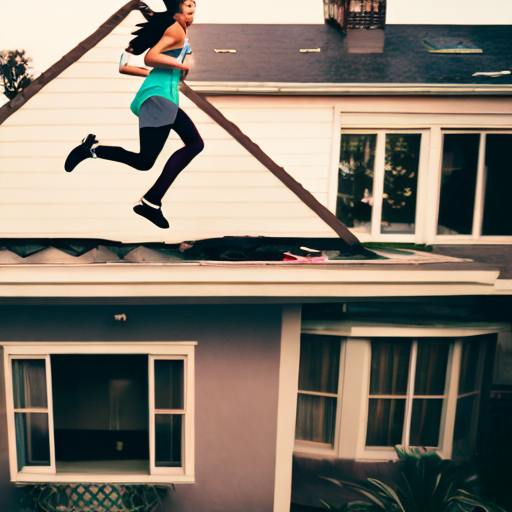

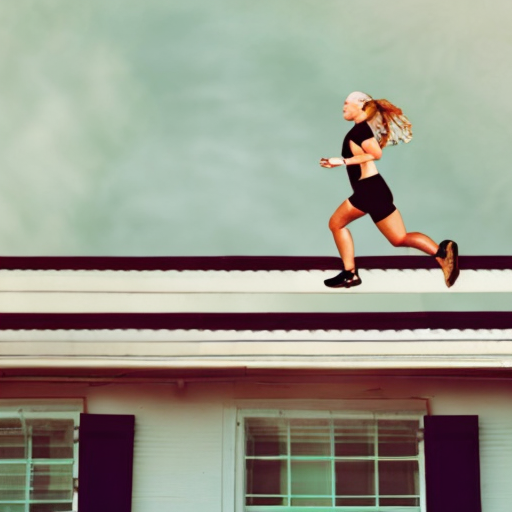

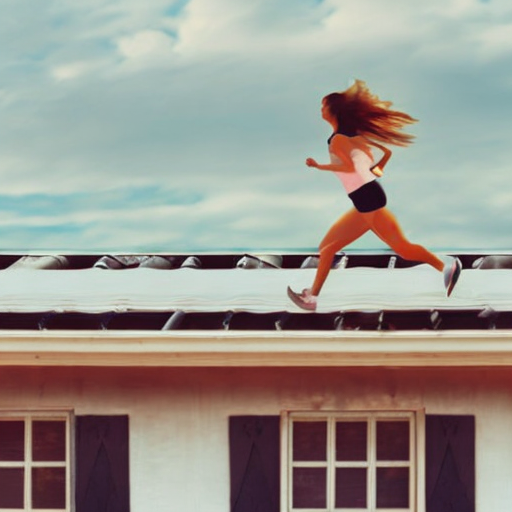

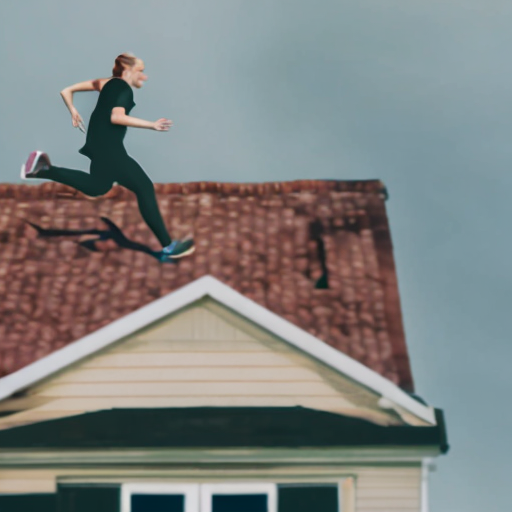

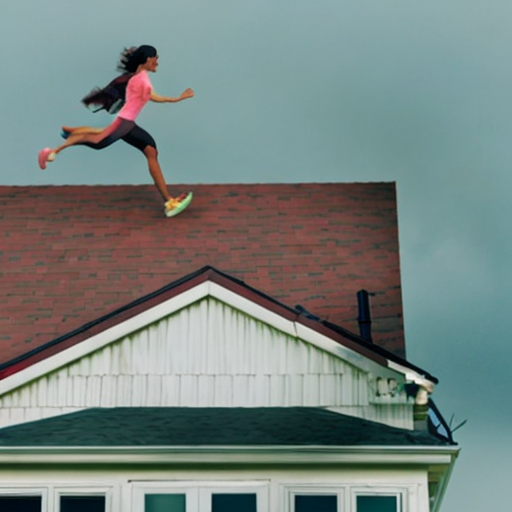

[None, None, None, None, None, None, None, None]

In [ ]:
rh_logo_dalle2sd_images = sd_img2img_generate_gpu(rh_prompt, rh_logo_dalle_images, num_images=2,
                                               strength=.75, guidance_scale=7.5, steps=25)
[display(image) for image in rh_logo_dalle2sd_images]

You can upload your own photo here if you'd like to try the img2img service on it.

Saving Screen Shot 2022-07-17 at 1.16.45 PM.png to Screen Shot 2022-07-17 at 1.16.45 PM.png


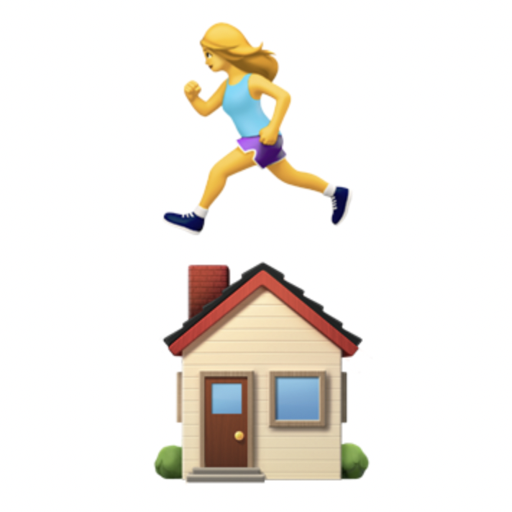

In [ ]:
from google.colab import files
from PIL import Image
from io import BytesIO

uploaded_img_bytes = files.upload()
uploaded_img = Image.open(BytesIO(list(uploaded_img_bytes.values())[0])).convert('RGB')
uploaded_img.resize((512, 512))

INFO | 2023-01-19 02:38:59,524 | Running sd_img2img_generate via SSH
INFO | 2023-01-19 02:39:04,464 | Time to send message: 4.93 seconds


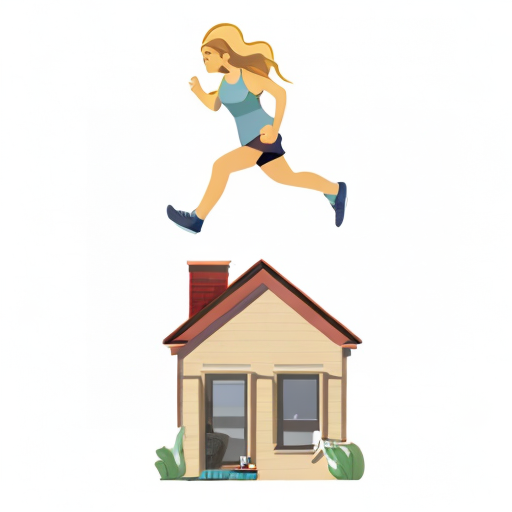

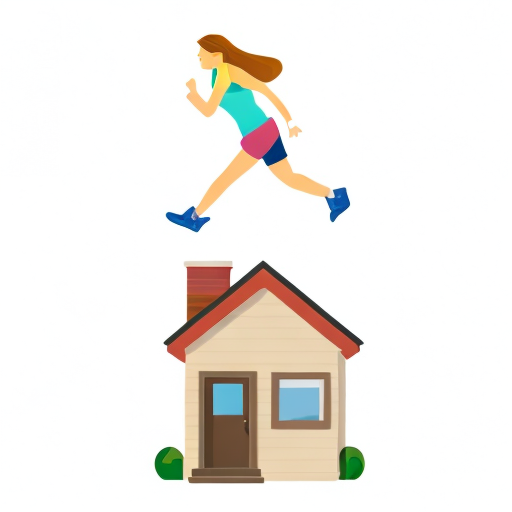

[None, None]

In [ ]:
my_prompt = 'A detailed photo of a woman running on the roof of a house.'
uploaded_sd_images = sd_img2img_generate_gpu(my_prompt, [uploaded_img],
                                            strength=.5, guidance_scale=7.5,
                                            num_images=2, steps=100)
[display(image) for image in uploaded_sd_images]

# Appendix: Upscaling (Note: memory constrained)

Finally, we can try upscaling an image that we like. Let's check the GPU memory again.

In [ ]:
gpu.run(['nvidia-smi'])
True

INFO | 2022-12-28 04:34:29,410 | Running command on rh-a10g: nvidia-smi


Wed Dec 28 04:34:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   27C    P0    56W / 300W |  17293MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

That's a bit tight, and probably won't work. Let's just put the upscaler on a V100. Note that Stable Diffusion upscaling is very memory intensive, so we enable attention slicing to save some memory at the expense of throughput. You can also try installing xformers and Triton to take advantage of memory-efficient attention.

In [ ]:
def sd_upscaler_generate(prompt, base_images, num_images=1,
                         steps=50, guidance_scale=7.5, attention_slicing='auto',
                         model_id="stabilityai/stable-diffusion-x4-upscaler"):
    # Here we're using Runhouse's object pinning to hold the model in GPU memory. See p01a for more details.
    import runhouse as rh
    from diffusers import StableDiffusionUpscalePipeline
    import torch
    pipe = rh.get_pinned_object(model_id + 'upscaler')
    if pipe is None:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        pipe = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16).to('cuda')
        pipe.enable_attention_slicing(attention_slicing)
        # pipe.enable_xformers_memory_efficient_attention = True
        rh.pin_to_memory(model_id + 'upscaler', pipe)
    torch.no_grad()
    ret = []
    for image in base_images:
        ret = ret + pipe(prompt,
                         image=image,
                         num_images_per_prompt=num_images,
                         num_inference_steps=steps,
                         guidance_scale=guidance_scale).images
    return ret

v100_gpu = rh.cluster(name='rh-v100', instance_type='V100:1', provider='cheapest')
# If you change anything inside of the `if pip is None` block, you'll need to clear the pins for your changes to take effect.
# v100_gpu.clear_pins()
sd_upscaler_generate_gpu = rh.send(fn=sd_upscaler_generate, hardware=gpu,
                                    reqs=['local:./', 'torch --upgrade --extra-index-url https://download.pytorch.org/whl/cu116',
                                   'diffusers', 'transformers', 'accelerate'],
                                    name='sd_upscaler_generate').save()

INFO | 2022-12-28 05:37:30,058 | Running sd_upscaler_generate via SSH
INFO | 2022-12-28 05:37:38,626 | Time to send message: 8.56 seconds


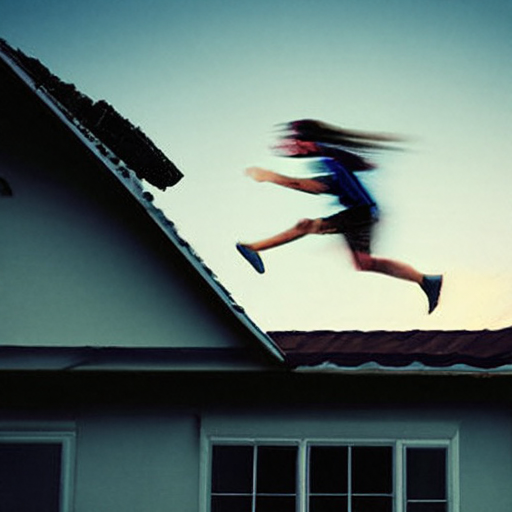

[None]

In [ ]:
sd_upscaled_images = sd_upscaler_generate_gpu(rh_prompt,
                                              [rh_logo_dalle_images[0].resize((128, 128))],
                                              guidance_scale=7.5,
                                              attention_slicing='max',
                                              num_images=1, steps=50)
[display(image) for image in sd_upscaled_images]